In [ ]:
    import numpy as np
    import pandas as pd
    from keras.layers import Dense, LSTM
    import matplotlib.pyplot as plt
    import tensorflow as tf

In [ ]:
    data_train = pd.read_csv('DailyDelhiClimateTrain.csv')
    data_train.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB


In [ ]:
    data_train.isnull().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

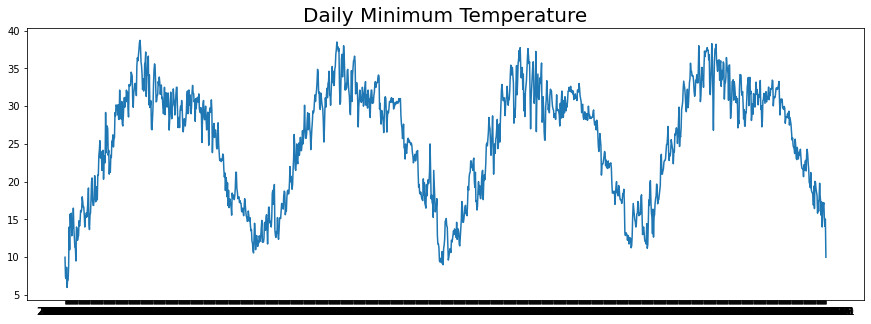

In [ ]:
    dates = data_train['date'].values
    temp  = data_train['meantemp'].values
     
     
    plt.figure(figsize=(15,5))
    plt.plot(dates, temp)
    plt.title('Daily Minimum Temperature',
              fontsize=20);

In [ ]:
    def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        series = tf.expand_dims(series, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size + 1))
        ds = ds.shuffle(shuffle_buffer)
        ds = ds.map(lambda w: (w[:-1], w[1:]))
        return ds.batch(batch_size).prefetch(1)

In [ ]:
    from tensorflow.keras import layers
    train_set = windowed_dataset(temp, window_size=60, batch_size=100, shuffle_buffer=1000)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
      tf.keras.layers.Bidirectional(layers.LSTM(64)),
      tf.keras.layers.Dense(64, activation="relu"),
      tf.keras.layers.Dense(32, activation="relu"),
      tf.keras.layers.Dense(1),
    ])

In [ ]:
    class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<2.2):
          print("\nMAE <2.2!")
          self.model.stop_training = True
    callbacks = myCallback()

In [ ]:
    optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set,epochs=100, callbacks=[callbacks])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 55ms/step - loss: 25.2284 - mae: 25.7284
Epoch 2/100
15/15 [==============================] - 1s 53ms/step - loss: 24.8001 - mae: 25.3001
Epoch 3/100
15/15 [==============================] - 1s 55ms/step - loss: 24.4560 - mae: 24.9560
Epoch 4/100
15/15 [==============================] - 1s 53ms/step - loss: 24.1250 - mae: 24.6250
Epoch 5/100
15/15 [==============================] - 1s 53ms/step - loss: 23.7552 - mae: 24.2552
Epoch 6/100
15/15 [====

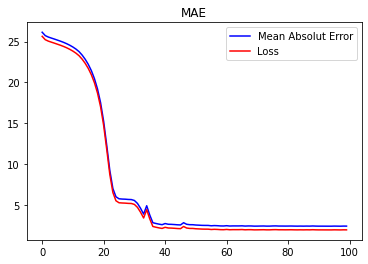

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
mae = history.history['mae']
loss = history.history['loss']
epochs = range(len(mae))
plt.plot(epochs, mae, 'b', label='Mean Absolut Error')
plt.plot(epochs, loss, 'r', label='Loss')
plt.title('MAE')
plt.legend(loc=0)
plt.figure()
plt.show()